
# Contours Visualization Analysis


In [3]:
from typing import List
import itertools
import os
import shutil
import uuid
from collections import Counter
from datetime import datetime, timedelta
from pathlib import Path
import subprocess
import tempfile
import time
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

# !pip install opencv-python-headless
import cv2

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError, HttpResponseError

  Using cached opencv_python_headless-4.5.4.58-cp38-cp38-manylinux2014_x86_64.whl (47.6 MB)


In [4]:
SAS_TOKEN = getpass.getpass() # of the whole "cmip6" folder in Azure.
URL_PREFIX = 'https://nasanex30analysis.blob.core.windows.net/cmip6'

In [118]:
###################################
# Download json files
###################################

azure_folder = "NEWcontours_3days_5K"

models = ["GISS_E2_1_G_ssp245", "GFDL_ESM4_ssp245", "GFDL_ESM4_ssp585", "GISS_E2_1_G_ssp585"]
years = list(range(2020,2030))

for model in models:
    
    for year in years:
        
        fp = f"{model}_{year}.json"
        sas_url = f"{URL_PREFIX}/{azure_folder}/{model}/{fp}?{SAS_TOKEN}"
        blob_client = BlobClient.from_blob_url(sas_url)

        if not os.path.exists(model):
            os.mkdir(model)
                
        with open(f"{model}/{fp}", "wb") as my_blob:
            download_stream = blob_client.download_blob()
            my_blob.write(download_stream.readall())


In [6]:
###################################
# Read all meta data into single df
###################################
%time

models = ["GISS_E2_1_G_ssp245", "GFDL_ESM4_ssp245", "GFDL_ESM4_ssp585", "GISS_E2_1_G_ssp585"]
dfs = []
for model in models:
    jsons = sorted([str(p) for p in Path(model).rglob("*.json")])
    df = pd.concat([pd.read_json(j) for j in jsons], axis=0)
    df['model'] = model
    dfs.append(df)
    
df_meta = pd.concat(dfs, axis=0).reset_index(drop=True)
df_meta

CPU times: user 18 µs, sys: 5 µs, total: 23 µs
Wall time: 26.5 µs


,days,type,name,center,area,projected,model
0,2020-01-01,daily,6c46a5,"[316.125, 77.125]",3080.5,"[[[295.875, 76.375]], [[296.125, 76.375]], [[2...",GISS_E2_1_G_ssp245
1,2020-01-01,daily,9b94c0,"[289.375, 68.625]",617.5,"[[[298.875, 66.625]], [[298.625, 66.625]], [[2...",GISS_E2_1_G_ssp245
2,2020-01-01,daily,2f6756,"[237.125, 66.125]",15076.5,"[[[276.125, 82.625]], [[275.375, 82.625]], [[2...",GISS_E2_1_G_ssp245
3,2020-01-01,daily,b50daa,"[249.875, 37.375]",2673.0,"[[[262.875, 31.625]], [[262.375, 31.625]], [[2...",GISS_E2_1_G_ssp245
4,2020-01-02,daily,086c49,"[314.875, 78.125]",4286.5,"[[[292.375, 83.125]], [[296.875, 83.125]], [[2...",GISS_E2_1_G_ssp245
...,...,...,...,...,...,...,...
181718,2029-12-31,rolling_sum,6df57e,"[232.375, 56.875]",66.5,"[[[234.875, 56.875]], [[234.875, 57.125]], [[2...",GISS_E2_1_G_ssp585
181719,2029-12-31,rolling_sum,5f1b05,"[341.125, 66.125]",135.5,"[[[345.875, 66.125]], [[345.625, 66.625]], [[3...",GISS_E2_1_G_ssp585
181720,2029-12-31,rolling_sum,c8bf65,"[317.875, 72.875]",10394.5,"[[[342.875, 75.375]], [[341.875, 76.125]], [[3...",GISS_E2_1_G_ssp585
181721,2029-12-31,rolling_sum,ca5d1e,"[278.875, 68.375]",7037.5,"[[[295.875, 65.625]], [[295.875, 65.875]], [[2...",GISS_E2_1_G_ssp585


In [7]:
###################################
# Daily contour stats per day across all climate models
###################################

df = df_meta[df_meta['type']=='daily'].groupby(['model','days']).agg({'area':['count','sum']})
df = df.reset_index()
df.columns = ['model','day','contour_count','total_area']
df['day'] = df['day'].astype('datetime64[ns]')
df.head()

,model,day,contour_count,total_area
0,GFDL_ESM4_ssp245,2020-01-01,4,2218.0
1,GFDL_ESM4_ssp245,2020-01-02,4,4570.5
2,GFDL_ESM4_ssp245,2020-01-03,5,6622.5
3,GFDL_ESM4_ssp245,2020-01-04,7,9515.5
4,GFDL_ESM4_ssp245,2020-01-05,4,14353.0


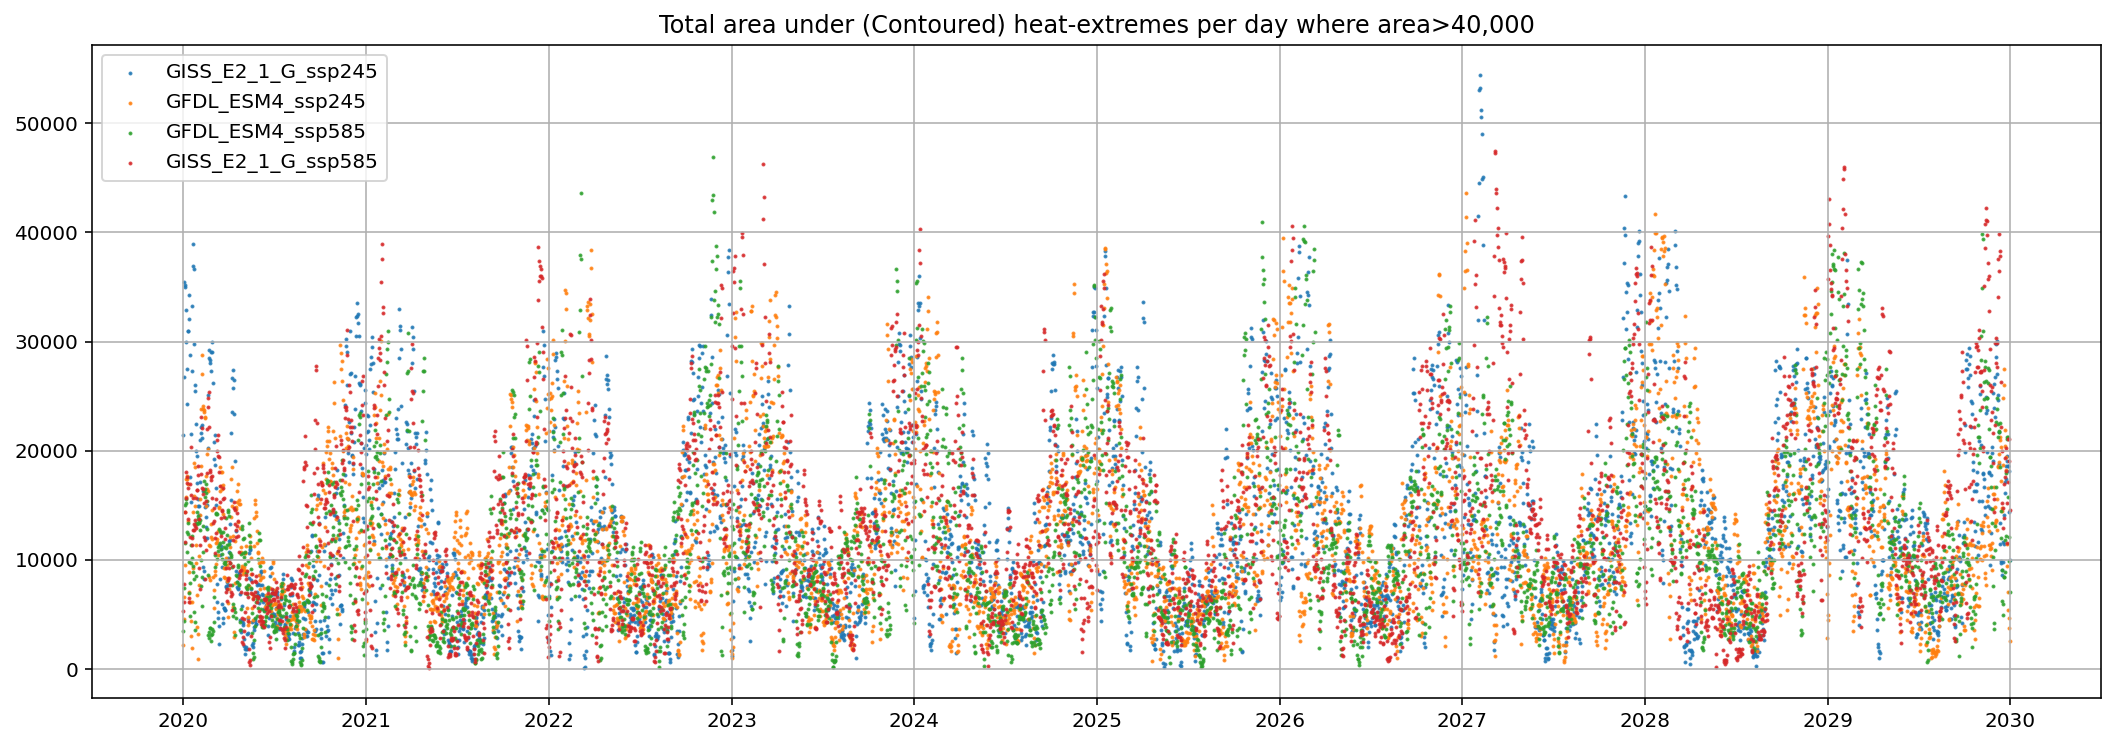

In [13]:
###################################
# Daily contour stats per day across all climate models
###################################

fig, ax = plt.subplots(1, 1, figsize=(18,6))

for model in models:
    
    filt = (df['model']==model) & (df['total_area'] > 100)
    
    y = df[filt]['total_area']
    x = df[filt]['day']
    ax.scatter(x, y, label=model, marker='.', s=4, alpha=.8);

ax.set_title("Total area under (Contoured) heat-extremes per day")
ax.grid()
ax.legend();

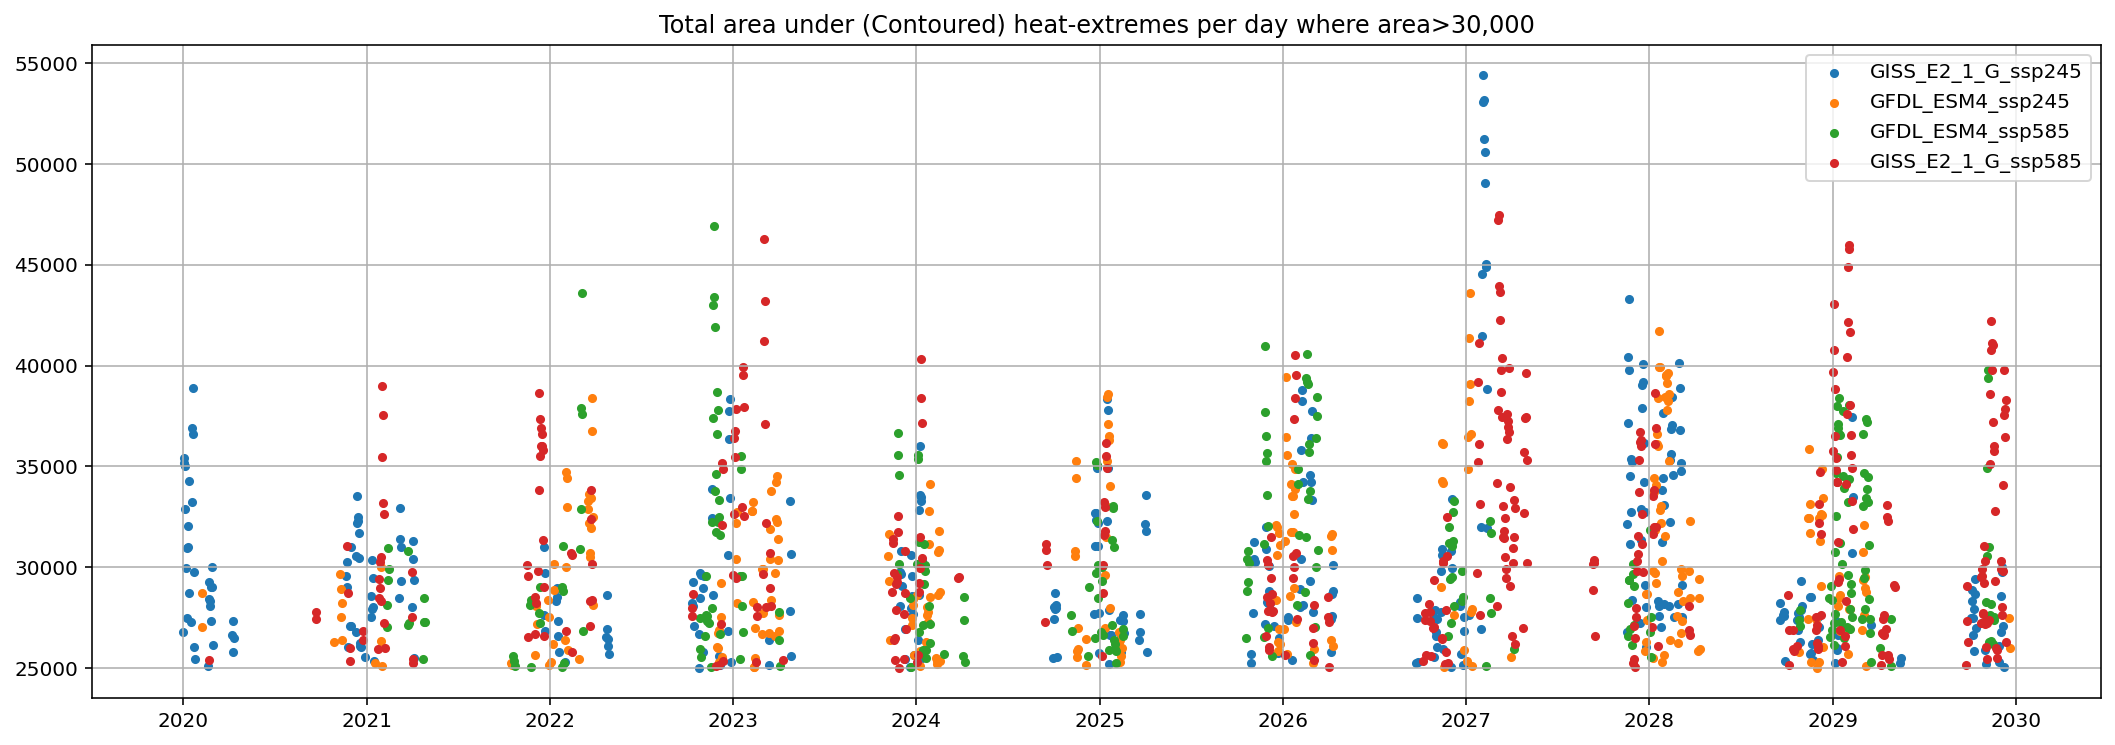

In [22]:
###################################
# Daily contour stats per day across all climate models
###################################

fig, ax = plt.subplots(1, 1, figsize=(18,6))

for model in models:
    
    filt = (df['model']==model) & (df['total_area'] > 25000)
    
    y = df[filt]['total_area']
    x = df[filt]['day']
    ax.scatter(x, y, label=model, marker='.', s=50, alpha=1);

ax.set_title("Total area under (Contoured) heat-extremes per day where area>30,000")
ax.grid()
ax.legend();